# [1] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Apply Logistic Regression on Amazon Fine Food Review (Bag Of Words), Find optimal value of hyperparameter, Check For The MultiCollinearity, Find the Most important Feature



## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [128]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# using the SQLite Table to read data.
con = sqlite3.connect(r'C:\Users\hp\Downloads\amazon-fine-food-reviews\database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 






In [129]:
filtered_data['Score'] = filtered_data['Score'].apply(lambda x : 1 if x > 3 else 0 )

In [130]:
filtered_data['Time'].head(2)

0    1303862400
1    1346976000
Name: Time, dtype: int64

In [131]:
import datetime
filtered_data["Time"] = filtered_data["Time"].map(lambda t: datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))



In [132]:
print(filtered_data.isnull().values.any())

False


In [134]:
print(filtered_data['Score'].value_counts(normalize=True))

1    0.843981
0    0.156019
Name: Score, dtype: float64


In [135]:
print(filtered_data.shape) #looking at the number of attributes and size of the data

(525814, 10)


## Observation:

1) No null value in Dataset.

2) Approx. 84 percentage of reviews are positive



## [1.2] Data Cleaning: Deduplication

Let check whether there are dupicate entry or not,it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.

In [136]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [137]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')


In [138]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape


(364173, 10)

In [139]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100


69.25890143662969

## Observation:

1) There was 31 percetage of data which was duplicate

In [140]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


## Observations:

1) Same User(Geetha Krishnan)  has multiple reviews ofwith the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  


2) It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

3) The method used for the removing the redundancy is to  first sort the data according to ProductId and then just keep the first similar product review and delelte the others. 

In [141]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [142]:

print(final.shape)
final['Score'].value_counts(normalize=True)


(364171, 10)


1    0.843178
0    0.156822
Name: Score, dtype: float64

In [143]:
final = final.sample(2000)

In [144]:
final.shape

(2000, 10)

## Observation:

1) The  two rows had  the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

## 1.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

We have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [145]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

        

1
The item came so fast and was well packaged and just as described.  Would totally do business with again.<br /><br />Thanks alot!!


In [146]:
import re
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english'))



#set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)


{'s', 'doing', 'shouldn', 'her', 'out', 'having', 'him', 'hers', 'll', 'how', 'haven', 'not', "mightn't", "needn't", 'up', "didn't", 'just', 'for', 'hadn', 'won', 'before', 'they', 'such', "shan't", "she's", 'should', "you're", 'he', 'the', 'through', "wasn't", 'own', 've', 'his', 'both', 're', 'being', 'but', 'of', 'will', 'nor', "aren't", 'was', 'only', 'at', 'below', 'in', 'had', 'while', 'further', 'these', 'hasn', "don't", 'been', "weren't", 'we', 'has', 'most', 'aren', 'an', 'then', 'until', 'all', 'with', 'if', 'wasn', 'or', 'o', 'ain', "hasn't", 'here', 'can', 'couldn', "wouldn't", "doesn't", "shouldn't", 'my', 'themselves', 'above', 'yourself', "haven't", "hadn't", 'yours', 'you', 'very', 'be', "won't", "couldn't", "mustn't", 'off', 'doesn', 'against', 'itself', 'me', 'ourselves', 'same', 'it', 'more', 'she', 'their', 'between', 'ma', 'once', 'than', 'whom', 'theirs', 'this', 'our', 'your', 'from', 'under', 'again', 'm', 'no', "isn't", 'so', 'a', 'y', 'am', 'did', 'because', '

In [147]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [148]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [149]:
final.shape

(2000, 11)

## Observation:

1) All The Stopwords From our review text has been removed

2) All the sentence containg HTML tag has been removed<br>

3) One more Column is added named as CleanedText which contain the review after applying text preprocessing

# [1.4] Bag of Words (BoW)

In [150]:

count_vect = CountVectorizer() 
final_counts = count_vect.fit_transform(final['CleanedText'].values)


In [151]:
final_counts.shape

(2000, 6375)

In [152]:
print(final_counts.shape)
print(type(final_counts))
A = pd.DataFrame(final_counts.toarray())
C = pd.DataFrame(final['Time'])
D = pd.DataFrame(final['Score'])
print(type(A))
A.tail()

(2000, 6375)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'pandas.core.frame.DataFrame'>


,0,1,2,3,4,5,6,7,8,9,...,6365,6366,6367,6368,6369,6370,6371,6372,6373,6374
1995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [153]:
from sklearn.preprocessing import StandardScaler 
df = StandardScaler().fit_transform(A)
print(df.shape)

(2000, 6375)


In [154]:
df = pd.DataFrame(A)
print (type(df))

<class 'pandas.core.frame.DataFrame'>


In [155]:

C = C.reset_index(drop=True)
C.shape
C.head(3)

,Time
0,2012-05-25 05:30:00
1,2006-02-16 05:30:00
2,2011-08-18 05:30:00


In [156]:
result = pd.concat([df, C ], axis=1)
result.shape
result.head()

,0,1,2,3,4,5,6,7,8,9,...,6366,6367,6368,6369,6370,6371,6372,6373,6374,Time
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2012-05-25 05:30:00
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2006-02-16 05:30:00
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2011-08-18 05:30:00
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2012-08-05 05:30:00
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2011-04-07 05:30:00


In [157]:
D = D.reset_index(drop=True)
D.shape
D.head(1)

,Score
0,1


In [158]:
final_result = pd.concat([result, D], axis=1)
final_result.shape
final_result.tail()

,0,1,2,3,4,5,6,7,8,9,...,6367,6368,6369,6370,6371,6372,6373,6374,Time,Score
1995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2011-12-12 05:30:00,1
1996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2012-06-11 05:30:00,1
1997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2009-04-25 05:30:00,1
1998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2010-05-10 05:30:00,1
1999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2011-02-22 05:30:00,1


In [159]:
sorted_new=final_result.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [160]:
sorted_new.shape

(2000, 6377)

# [1.5] Implementing  Logistic Regression <br>


In [193]:

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.naive_bayes import MultinomialNB
import math
from sklearn.cross_validation import train_test_split
# from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV

from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression

In [162]:
sorted_new.head(1)

,0,1,2,3,4,5,6,7,8,9,...,6367,6368,6369,6370,6371,6372,6373,6374,Time,Score
821,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2004-04-19 05:30:00,1


In [184]:
X = np.array(sorted_new.iloc[:,0:6375]) 
y = np.array(sorted_new['Score'])

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [186]:
print(X.shape)
print(y.shape)
type(X)


(2000, 6375)
(2000,)


numpy.ndarray

In [187]:
# split the data set into train and test
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=0)



   


In [188]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

In [189]:
model = GridSearchCV(LogisticRegression(penalty ='l1'), tuned_parameters, scoring = 'f1', cv=3)


In [190]:
model.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.01, 1, 100, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [191]:
print(model.score(X_test, y_test))

0.9300291545189504


In [192]:
print(model.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


##### The optimal value of C we are getting is 1 by doing GridSearchCv and we are getting the accuracy of 93 percent which is very good, In K-nn, Naive Bayes we were getting the accuracy around 85 percent. Here we are using L1 Regularization. 

In [203]:
clf = LogisticRegression(C=1, penalty='l1');
model=clf.fit(X_train, y_train);
w = clf.coef_
sparsity = np.mean(w.ravel()==0)*100
print('Sparsity is' ,sparsity)
print(np.count_nonzero(w))


Sparsity is 95.10588235294118
312


In [202]:
clf = LogisticRegression(C=1, penalty='l2');
model=clf.fit(X_train, y_train);
w = clf.coef_
sparsity = np.mean(w.ravel()==0)*100
print('Sparsity is' ,sparsity)
print(np.count_nonzero(w))

Sparsity is 9.992156862745098
5738


In [206]:
clf = LogisticRegression(C=100, penalty='l1');
model=clf.fit(X_train, y_train);
w = clf.coef_
sparsity = np.mean(w.ravel()==0)*100
print('Sparsity is' ,sparsity)
print(np.count_nonzero(w))


Sparsity is 91.70196078431373
529


In [207]:
clf = LogisticRegression(C=100, penalty='l2');
model=clf.fit(X_train, y_train);
w = clf.coef_
sparsity = np.mean(w.ravel()==0)*100
print('Sparsity is' ,sparsity)
print(np.count_nonzero(w))


Sparsity is 9.992156862745098
5738


#### For a fix value of C both L1 and L2 regularization are giving diferent value . The number of non zero feature in case of L2 regularizer is very high compare to L1. As the value of C increases the number of non zero feature for L1 regularizer increases which means our model is overfitting.

# [1.6] Performance Metrices

In [209]:
clf = LogisticRegression(C=1, penalty='l1');
model=clf.fit(X_train, y_train);
pred = (model.predict(X_test))

In [210]:
x = confusion_matrix(y_test,pred)
x

array([[ 33,  36],
       [ 12, 319]], dtype=int64)

In [211]:
True_Negative = x[0][0]
False_Negative = x[0][1]
False_Positive = x[1][0]
True_Positive = x[1][1]

Total_Negative = True_Negative + False_Positive
Total_Positive = False_Negative + True_Positive

TPR = float(True_Positive/Total_Positive)
print("The True Positive Rate is ", TPR)

TNR = float(True_Negative/Total_Negative)
print("The True Negative Rate is ", TNR)

FNR = float(False_Negative/Total_Positive)
print("The False Negative Rate is ", FNR)

FPR = float(False_Positive/Total_Negative)
print("The False Positive Rate is ", FPR)

The True Positive Rate is  0.8985915492957747
The True Negative Rate is  0.7333333333333333
The False Negative Rate is  0.10140845070422536
The False Positive Rate is  0.26666666666666666


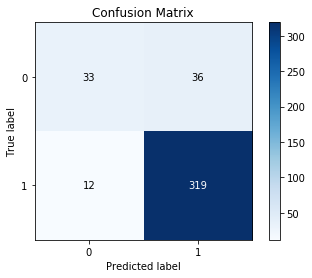

In [212]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, pred, normalize=False)


In [213]:
print(classification_report(y_test ,pred))




             precision    recall  f1-score   support

          0       0.73      0.48      0.58        69
          1       0.90      0.96      0.93       331

avg / total       0.87      0.88      0.87       400



# [1.7] Feature Importance

In [214]:
all_feat = count_vect.get_feature_names()

In [225]:
feature_coefs = pd.DataFrame(
    data = list(zip(all_feat, model.coef_[0])),
    columns = ['feature', 'coef'])

feature_coefs.sort_values(by='coef', ascending=False)



,feature,coef
6260,wonder,2.266678
2429,great,2.238909
2200,friend,2.023151
488,best,1.799976
391,bar,1.554187
1456,definit,1.530390
4076,perfect,1.528264
3258,local,1.488048
161,amaz,1.483855
6344,yummi,1.343373


##### Positive Value of Coef indicate positive class. The top word in positive class is wonder, and top word in negative class is white Let check for the multicollinearity

# [1.8] Checking For Multicollinearity<br>

##### For checking multicollinearity we will add some noise to each feature and compare our feature again

In [226]:
X = pd.DataFrame(X)
y = pd.DataFrame(y)

In [227]:
X.shape

(2000, 6375)

In [229]:
X = X + np.random.normal(0,0.01)

In [230]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(penalty ='l1'), tuned_parameters, scoring = 'f1', cv=3)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.9313868613138686


In [231]:
all_feat = count_vect.get_feature_names()

In [232]:
clf = LogisticRegression(C=1, penalty='l1');
model=clf.fit(X_train, y_train);
w = clf.coef_

In [233]:
feature_coefs = pd.DataFrame(
    data = list(zip(all_feat, model.coef_[0])),
    columns = ['feature', 'coef'])

feature_coefs.sort_values(by='coef', ascending=False)



,feature,coef
6260,wonder,2.266366
2429,great,2.239447
2200,friend,2.022362
488,best,1.800386
391,bar,1.554295
1456,definit,1.531641
4076,perfect,1.528748
3258,local,1.488051
161,amaz,1.484105
6344,yummi,1.342858


#### We can observe that noise has not affected much to our feature,only a slight change has occur like. the value of best feature was 1.79 and now it is showing 1.80 and this type of change has occur only in few of the feature . So we can conclude that feature are not multicollinear.